# Mintervention Aware Optimization

This notebook demonstrates Python algorithms for optimal control constrained by keepout sets. We compare barrier methods to the new Mintervention-aware optimization

In [13]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy.linalg as LA
%matplotlib inline

# David McPherson's personal colors for plotting:
# Rows sorted by LAB L-value : 50, 20, 70
# Columns sorted by color : Rust, Turquoise, Sand, Indigo, Teal, dd, dd, Gray
colors = [['#cf4c34','#078752','#6333ed','#d6ca54','#0ca0ad','#2ea62a','#c96b0d','#d947bb','#777777'],
          ['#4C1C13','#073824','#000000','#000000','#000000','#000000','#000000','#000000','#4D4D4D'],
          ['#FF745A','#0BD480','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#ABABAB']]

plt.rcParams['font.sans-serif'] = "Gill Sans"
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "Georgia"
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 100

In [14]:
# Import custom libraries
import dlqr
import dynamics as dyn

In [15]:
# Simplify plots
def muteAxes(ax):
    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set ticks
    #x_ticks = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
    #ax.xaxis.set_ticks(x_ticks)
    #y_ticks = [-4,-3,-2,-1,0,1,2]
    #ax.yaxis.set_ticks(y_ticks)

    ax.tick_params(direction='in')
    for xb in range(-6,7):
        for yb in range(-4,4):
            rect = mplt.patches.Rectangle((xb+0.05,yb+0.05),0.9,0.9,color='#EEEEEE')
            ax.add_patch(rect)
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='x', colors='#777777')
    ax.yaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')

## Load the Barriers and test them

In [16]:
dubins = dyn.DubinsCarBrakelessDynamics()
timestep_length = 0.01

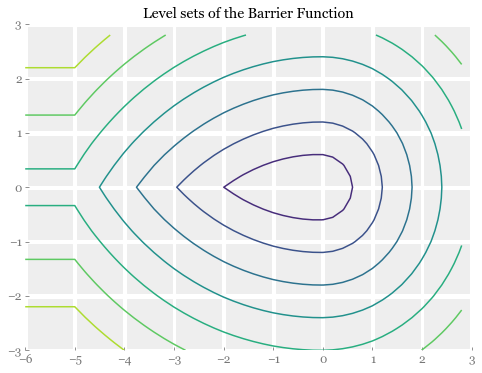

In [17]:
# Load the Safe Sets
import level_sets
safeLevel = level_sets.GriddedLevelSetFunction("dubins_reachset.json") # radius of obstacle is 1.8

# Setup the figure
fig = plt.figure(figsize=[8,6])
plt.axis([-6,3,-3,3])
ax = fig.axes[0]
muteAxes(ax)

# Plot the safe set
delta = 0.2
x = np.arange(-6.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
z = np.array([safeLevel.value([ex,ey,0]) for ex,ey in zip(X.flatten(),Y.flatten())])
Z = z.reshape(X.shape)
CS = plt.contour(X, Y, Z)

# Plot the gradient of the levels (the direction the controller will choose to go)
u = np.array([safeLevel.gradient([ex,ey,0])[0] for ex,ey in zip(X.flatten(),Y.flatten())])
U = u.reshape(X.shape)
v = np.array([safeLevel.gradient([ex,ey,0])[1] for ex,ey in zip(X.flatten(),Y.flatten())])
V = v.reshape(X.shape)
#plt.quiver(X,Y, U,V)

plt.title('Level sets of the Barrier Function')
plt.show()

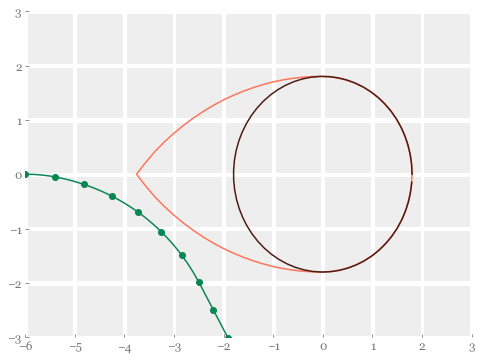

In [18]:
# Setup the figure
fig = plt.figure(figsize=[8,6])
plt.axis([-6,3,-3,3])
ax = fig.axes[0]
muteAxes(ax)

# Test the safe set with controls that drive straight into the obstacle
dubins = dyn.DubinsCarBrakelessDynamics()
safe_dubins = dyn.MinimumInterventionDynamicsWrapper(dubins,safeLevel)
timestep_length = 0.01

# Forward simulate the dynamics with zero control
N = 400
states_init = np.zeros((safe_dubins.dimZ,N+1))
control_init = np.zeros((safe_dubins.dimU,N))
states_init[:,0] = np.array([-6,0,0])
for i in np.arange(0,N):
    control_init[:,i] = np.zeros((safe_dubins.dimU,))
    states_init[:,i+1] = states_init[:,i] + timestep_length * safe_dubins.f(states_init[:,i],control_init[:,i])

# Plot the safe set intervention behavior on a mindless controller
CS = plt.contour(X, Y, Z, [0], colors = [colors[2][0]])

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

plt.plot(1.8*np.cos(np.arange(0,2*np.pi,0.1)),1.8*np.sin(np.arange(0,2*np.pi,0.1)),color=colors[1][0])

In [19]:
def muteAxes(ax):
    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set ticks
    x_ticks = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
    ax.xaxis.set_ticks(x_ticks)
    y_ticks = [-4,-3,-2,-1,0,1,2]
    ax.yaxis.set_ticks(y_ticks)

    ax.tick_params(direction='in')
    for xb in range(-6,7):
        for yb in range(-4,4):
            rect = mplt.patches.Rectangle((xb+0.05,yb+0.05),0.9,0.9,color='#EEEEEE')
            ax.add_patch(rect)
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='x', colors='#777777')
    ax.yaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')

## Set the Agent's goals

In [20]:
# Define the Agent's objective function
import objective_functions as of
import quadratic_objectives as qof
import avoidance_objective as caof

runningControlCost = qof.QuadraticControlCost(dlqr.QuadraticForm(dubins.dimU,np.diag([0.010]),np.zeros((dubins.dimU,1)),0))

Qprox = np.diag([1,1,0])
#goal_state = states_init[:,N]
goal_state = np.array([4,0,0])
terminalCost = of.TerminalCost(qof.QuadraticStateCost(
        dlqr.QuadraticForm(dubins.dimZ,Qprox,
                           -2*Qprox*np.matrix(goal_state).T,
                           np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
        ) * 80)

Agent_objective = runningControlCost*1

## Optimize trajectory with iLQR

In [21]:
import ilqr

mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,timestep_length ,safe_dubins,Agent_objective,terminal_cost = terminalCost*2,neverRetreat=True,ITER_NUM=15)

Initialization's cost is  133.52732740832258
1 28.05466847210434
2 13.105064405854304
3 9.995480424231102
4 8.630244468744744
5 7.367704266800532
6 7.354406301204701
7 6.333966012582115
8 6.185811670219604
9 5.563916460836847
10 5.506101414048031
11 5.506101414048031
12 5.506101414048031
13 5.506101414048031
14 5.506101414048031


<function matplotlib.pyplot.show(close=None, block=None)>

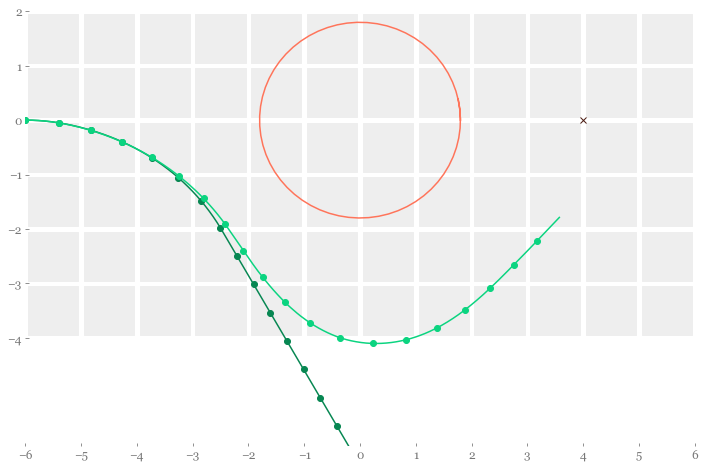

In [22]:
# Plot the resultant trajectories

# Setup the figure and axes
fig = plt.figure(figsize=[12,8])
plt.axis([-6,6,-6,2])
ax = fig.axes[0]
muteAxes(ax)

dotTimes = np.arange(0,N,20)
# Plot the initialization
plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,dotTimes],
         states_init[1,dotTimes],
         'ro',color=colors[0][1])

# Plot the iterative LQR optimized trajectory
plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
plt.plot(mintervener_method_states[0,dotTimes],
         mintervener_method_states[1,dotTimes],
         'ro',color=colors[2][1])

# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the obstacle circle
plt.plot(1.8*np.cos(np.arange(0,2.1*np.pi,0.1)),1.8*np.sin(np.arange(0,2.1*np.pi,0.1)),color=colors[2][0])

plt.show
#plt.plot(statesLin[0,:],statesLin[1,:],color=colors[0][2])